Chọn dataset:
1. Zachary's Karate Club
2. Les Miserables Network
3. Florentine Families Network
Nhập lựa chọn (1-3): 1

=== Phân tích mạng ===
Số node: 34
Số cạnh: 78
Clustering trung bình: 0.571


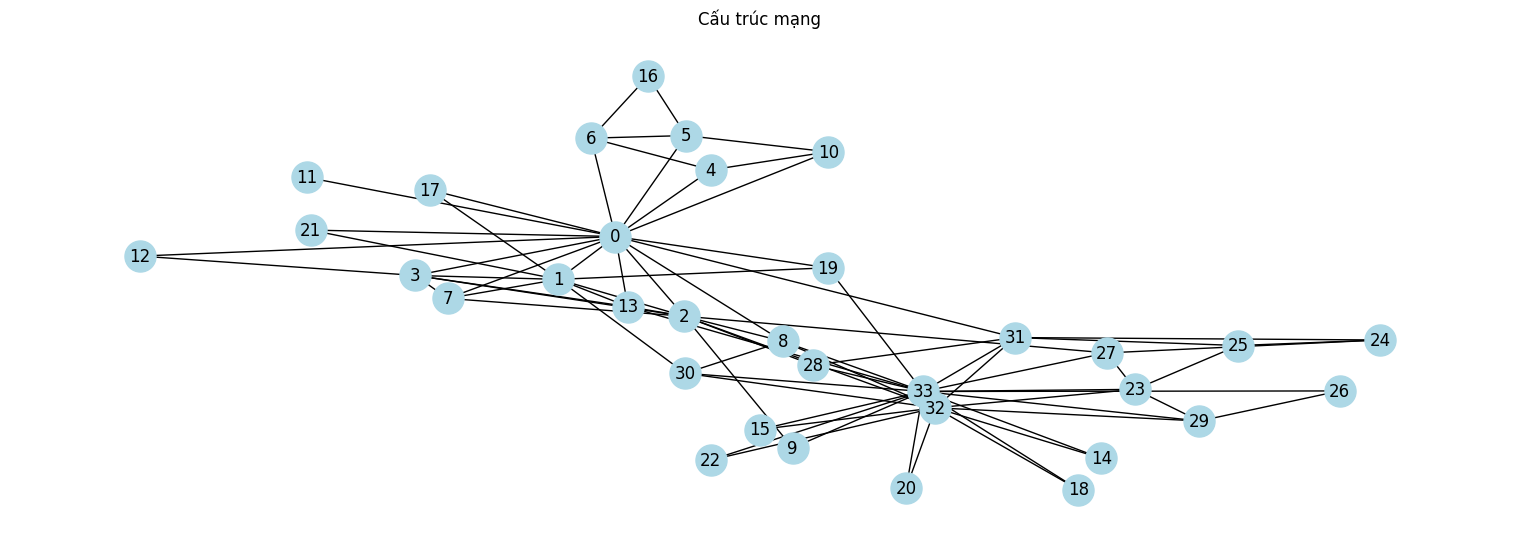

Train edges: 63
Test positive edges: 15
Test negative edges: 15

Bảng so sánh kết quả cho các phương pháp:
                    Method       AUC  Accuracy  Precision    Recall  F1-score
0         Common Neighbors  0.493333  0.400000   0.400000  0.400000  0.400000
1      Jaccard Coefficient  0.422222  0.400000   0.400000  0.400000  0.400000
2              Adamic-Adar  0.515556  0.400000   0.400000  0.400000  0.400000
3  Preferential Attachment  0.702222  0.466667   0.481481  0.866667  0.619048


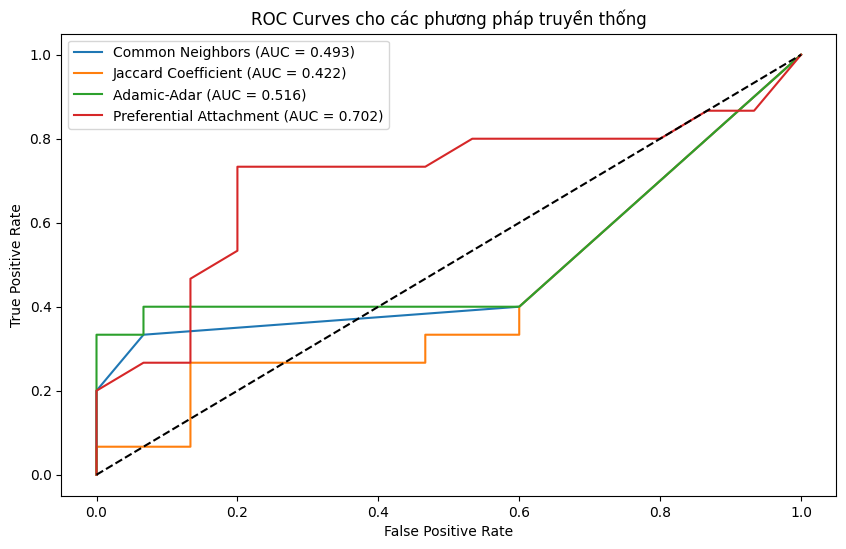


Kết quả AUC cho các phương pháp:
Common Neighbors: 0.493
Jaccard Coefficient: 0.422
Adamic-Adar: 0.516
Preferential Attachment: 0.702

Bảng kết quả mở rộng với Random Forest:
                    Method       AUC  Accuracy  Precision    Recall  F1-score
0         Common Neighbors  0.493333  0.400000   0.400000  0.400000  0.400000
1      Jaccard Coefficient  0.422222  0.400000   0.400000  0.400000  0.400000
2              Adamic-Adar  0.515556  0.400000   0.400000  0.400000  0.400000
3  Preferential Attachment  0.702222  0.466667   0.481481  0.866667  0.619048
4            Random Forest  0.777778  0.555556   0.400000  0.666667  0.500000


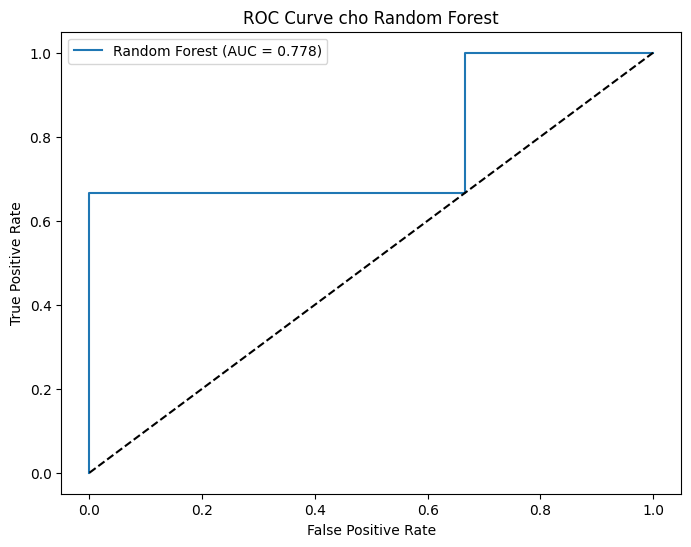

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class LinkPrediction:
    def __init__(self, dataset='karate'):
        """
        Khởi tạo với dataset đã cho.

        Parameters:
            dataset (str): Tên dataset ('karate', 'les', 'florentine')
        """
        if dataset == 'karate':
            self.G = nx.karate_club_graph()
        elif dataset == 'les':
            self.G = nx.les_miserables_graph()
        elif dataset == 'florentine':
            self.G = nx.florentine_families_graph()
        else:
            raise ValueError("Dataset không hợp lệ")

    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số node: {self.G.number_of_nodes()}")
        print(f"Số cạnh: {self.G.number_of_edges()}")
        print(f"Clustering trung bình: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title("Cấu trúc mạng")
        plt.show()

    def prepare_data(self):
        """Chuẩn bị dữ liệu train và test."""
        edges = list(self.G.edges())
        np.random.seed(42)
        np.random.shuffle(edges)

        n_test = int(len(edges) * 0.2)
        self.test_edges = edges[:n_test]
        self.train_edges = edges[n_test:]

        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(self.test_edges)

        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        self.test_non_edges = non_edges[:n_test]
        print(f"Train edges: {len(self.train_edges)}")
        print(f"Test positive edges: {len(self.test_edges)}")
        print(f"Test negative edges: {len(self.test_non_edges)}")

    def extract_features(self, G, u, v):
        """Trích xuất features cho các node pairs."""
        cn = len(list(nx.common_neighbors(G, u, v)))
        jc = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        aa = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
        pa = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
        return [cn, jc, aa, pa]

    def prepare_ml_data(self, G, positive_edges, negative_edges):
        """Tạo dữ liệu cho machine learning."""
        X = [self.extract_features(G, u, v) for u, v in positive_edges + negative_edges]
        y = [1] * len(positive_edges) + [0] * len(negative_edges)
        return np.array(X), np.array(y)

    def evaluate_ml(self):
        """Huấn luyện mô hình ML và đánh giá."""
        X, y = self.prepare_ml_data(self.train_G, self.test_edges, self.test_non_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # Tính các metric
        auc = roc_auc_score(y_test, y_pred_proba)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Tạo DataFrame mới cho Random Forest
        rf_results = pd.DataFrame([{
            "Method": "Random Forest",
            "AUC": auc,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }])

        # Concatenate với kết quả cũ
        self.results_df = pd.concat([self.results_df, rf_results], ignore_index=True)

        # Hiển thị bảng kết quả
        print("\nBảng kết quả mở rộng với Random Forest:")
        print(self.results_df)

        # Vẽ ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve cho Random Forest')
        plt.legend()
        plt.show()


    def evaluate_baselines(self):
        """Đánh giá các phương pháp truyền thống."""
        methods = {
            'Common Neighbors': lambda u, v: len(list(nx.common_neighbors(self.train_G, u, v))),
            'Jaccard Coefficient': lambda u, v: list(nx.jaccard_coefficient(self.train_G, [(u, v)]))[0][2],
            'Adamic-Adar': lambda u, v: list(nx.adamic_adar_index(self.train_G, [(u, v)]))[0][2],
            'Preferential Attachment': lambda u, v: list(nx.preferential_attachment(self.train_G, [(u, v)]))[0][2],
        }

        results = []

        for name, score_func in methods.items():
            # Tính điểm cho positive và negative edges
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            # Tạo y_true và y_scores
            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            y_pred = [1 if score > 0 else 0 for score in y_scores]  # Dự đoán nhị phân

            # Tính các metric
            auc = roc_auc_score(y_true, y_scores)
            acc = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)

            # Lưu kết quả
            results.append({
                "Method": name,
                "AUC": auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1
            })

        # Chuyển kết quả thành DataFrame
        self.results_df = pd.DataFrame(results)
        print("\nBảng so sánh kết quả cho các phương pháp:")
        print(self.results_df)

        # Vẽ ROC Curves
        plt.figure(figsize=(10, 6))
        for name, score_func in methods.items():
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            fpr, tpr, _ = roc_curve(y_true, y_scores)

            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_true, y_scores):.3f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves cho các phương pháp truyền thống')
        plt.legend()
        plt.show()

        print("\nKết quả AUC cho các phương pháp:")
        # Sử dụng results_df thay vì results để in kết quả AUC
        for _, row in self.results_df.iterrows():
            print(f"{row['Method']}: {row['AUC']:.3f}")

    def run_experiment(self):
        """Chạy thử nghiệm hoàn chỉnh."""
        self.analyze_network()
        self.prepare_data()
        self.evaluate_baselines()
        self.evaluate_ml()

if __name__ == "__main__":
    print("Chọn dataset:")
    print("1. Zachary's Karate Club")
    print("2. Les Miserables Network")
    print("3. Florentine Families Network")
    choice = input("Nhập lựa chọn (1-3): ")
    datasets = {'1': 'karate', '2': 'les', '3': 'florentine'}

    if choice in datasets:
        lp = LinkPrediction(dataset=datasets[choice])
        lp.run_experiment()
    else:
        print("Lựa chọn không hợp lệ!")


Nhận xét về kết quả AUC và bảng mở rộng với Random Forest:
Kết quả AUC:

Preferential Attachment có AUC cao nhất (0.702), cho thấy đây là phương pháp dự đoán liên kết tốt nhất trong nhóm các phương pháp truyền thống. AUC cao phản ánh khả năng phân biệt giữa các liên kết thực sự và các không liên kết hiệu quả.
Adamic-Adar (0.516) và Common Neighbors (0.493) có AUC tương đối thấp, cho thấy hiệu quả dự đoán của chúng kém hơn so với Preferential Attachment.
Jaccard Coefficient có AUC thấp nhất (0.422), cho thấy phương pháp này yếu trong việc phân biệt các liên kết tiềm năng.
Bảng kết quả mở rộng với Random Forest:

Random Forest đạt AUC cao nhất (0.777), Accuracy (0.555), Precision (0.400), Recall (0.667), và F1-score (0.500), vượt trội so với các phương pháp truyền thống.

Preferential Attachment có Accuracy và Recall cao, đặc biệt là Recall (0.867), cho thấy phương pháp này có khả năng nhận diện các liên kết tiềm năng tốt.

Các phương pháp truyền thống như Common Neighbors, Jaccard Coefficient, và

Adamic-Adar có kết quả tương đối đồng đều và kém hiệu quả trong hầu hết các chỉ số (Accuracy, Precision, Recall), chỉ đạt Accuracy khoảng 0.4 và F1-score thấp.

Nhận xét tổng quan:
Random Forest vượt trội trong việc dự đoán liên kết so với các phương pháp truyền thống, với AUC cao, Accuracy và Recall ấn tượng.

Preferential Attachment là phương pháp tốt thứ hai, đặc biệt với Recall cao, cho thấy khả năng phát hiện các liên kết tiềm năng.

Các phương pháp truyền thống như Common Neighbors, Jaccard Coefficient, và Adamic-Adar cần cải thiện và khó cạnh tranh với Random Forest trong dự đoán liên kết.

Tóm lại, Random Forest là lựa chọn tốt nhất trong thử nghiệm này, trong khi các phương pháp truyền thống chỉ có hiệu quả ở mức cơ bản và có thể không đủ mạnh mẽ cho các bài toán phức tạp hơn.